# House Kaggle Challenge, predicting Sale Price

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge

In [2]:
data=pd.read_csv('/Users/chloeguiver/code/Cguiver26/House_Kaggle/train.csv')
test=pd.read_csv('/Users/chloeguiver/code/Cguiver26/House_Kaggle/test.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#defining X and y
X = data.drop(columns=['SalePrice'])
y = data.SalePrice
X.shape

(1460, 80)

## EDA

<br>
checking for duplicates that could cause data leakage

In [5]:

X.duplicated().count()

1460

In [6]:
X.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

__Missing Values__

In [7]:

# Number of missing values in each column of training (X) data
missing_count=X.isnull().sum().sort_values(ascending=False)
missing_count[missing_count>0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageCond        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtFinType1      37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

Heatmap to visualise the blank values in the dataset

<AxesSubplot:>

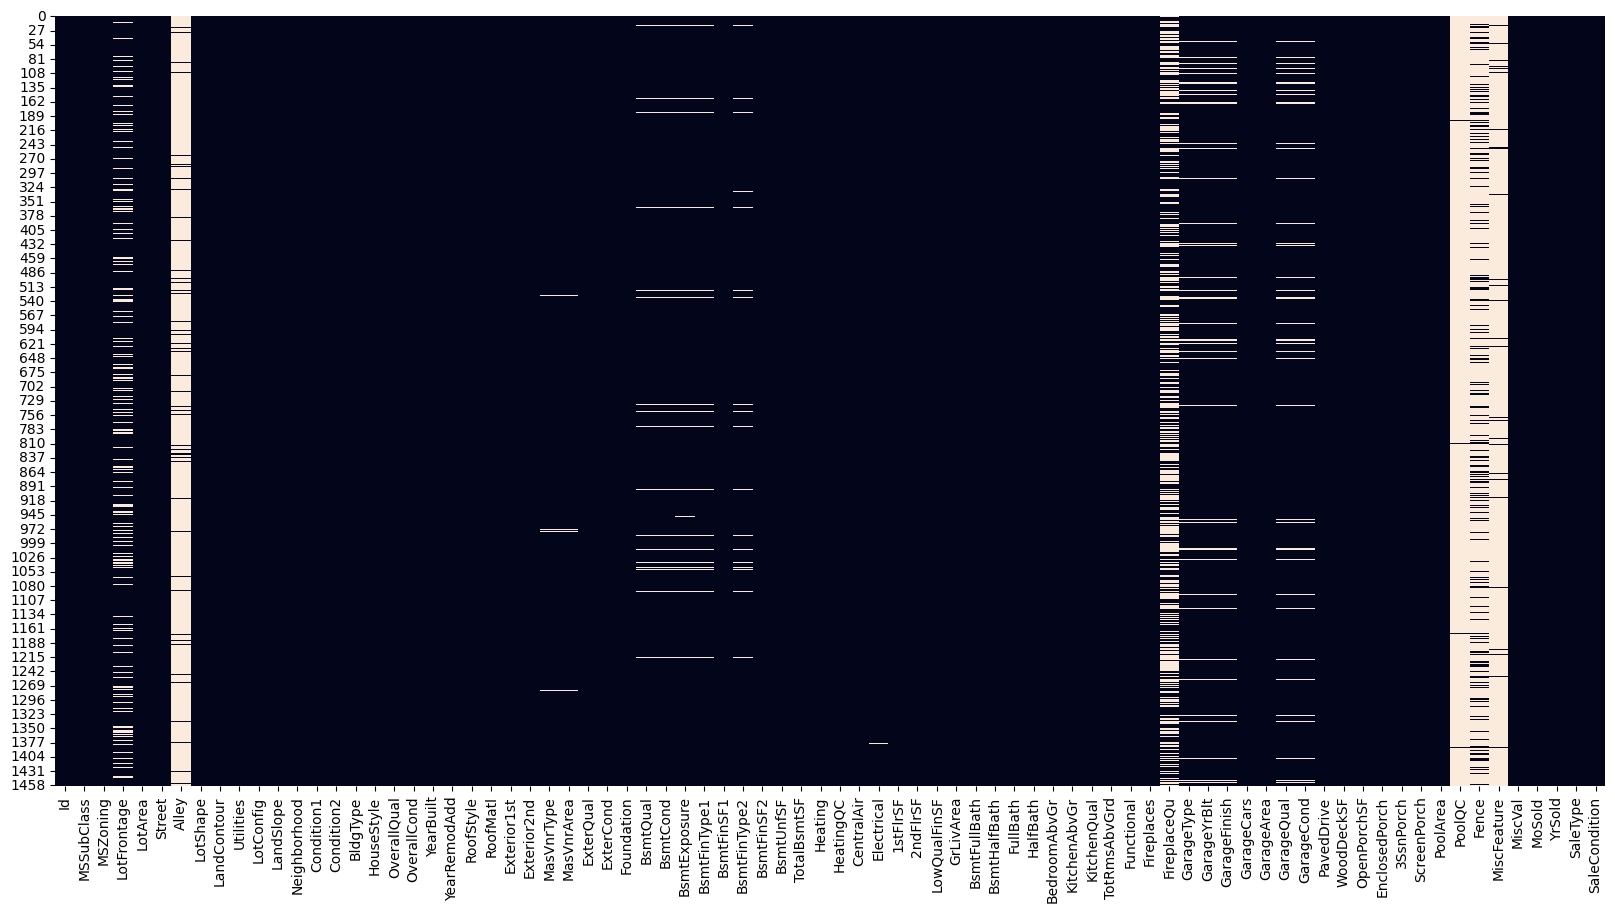

In [8]:
plt.figure(figsize=(20,10))
sns.heatmap(X.isnull(), cbar=False)

PoolQC,MiscFeature and Alley missing values are actually where there are no alley or pool etc. so this can be added as this.

In [9]:
features=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
for i in features:
    X[i].replace(np.nan, "NA", inplace=True)
    test[i].replace(np.nan, "NA", inplace=True)

In [10]:
X.isnull().sum().sort_values(ascending=False)

LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageFinish      81
GarageQual        81
                ... 
Exterior2nd        0
Exterior1st        0
RoofMatl           0
RoofStyle          0
SaleCondition      0
Length: 80, dtype: int64

__Numeric Values__

In [11]:
X.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

In [12]:
numeric_values=X.select_dtypes(include=['int64','float64'])
numeric_na=numeric_values.isna().sum().sort_values(ascending=False)
numeric_na[numeric_na>0]

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

In [13]:
numeric_values=numeric_values.columns.drop(['Id'])
numeric_values

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

__Categoric Values__

In [14]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()

In [15]:
feat_categorical_nunique.sum()

257

Investigating categories where there are too many different variables (ie. greater than 7) as these are less effective for encoding. 

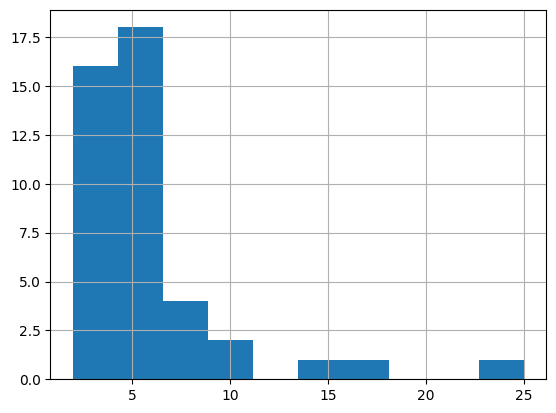

In [16]:
feat_categorical_nunique.hist();

In [17]:
categoric_values_small=list(feat_categorical_nunique[feat_categorical_nunique<7].index)

In [18]:
len(categoric_values_small)

34

### Basic Pipeline
<br>
Building a preprocessing pipeline that uses:
<br> For Numeric: simple imputer (imputing the mean) and standard scaling.
<br> For categoric features uses simple imputer (most frequent values) and OneHotEncoder for values that have less than 7 unique values.

In [19]:
num_transfomer=Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaling',StandardScaler()),
])
cat_transformer=Pipeline([
    ('imputer_cat',SimpleImputer(strategy='most_frequent')),
    ('Encoder',OneHotEncoder(handle_unknown='ignore',sparse=False))
])
preproc_baseline=ColumnTransformer([
    ('cat_trans',cat_transformer,categoric_values_small),
    ('num_trans',num_transfomer,numeric_values)
])
preproc_baseline

ColumnTransformer(transformers=[('cat_trans',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'Bsm...
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object'))])

In [20]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(1460, 188)

In [21]:
tree = DecisionTreeRegressor()
pipe_baseline=make_pipeline(preproc_baseline,tree)
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_trans',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'Ext...
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object'))])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### Cross-Validate

Competition submissions are evaluted on RMSE between the predicted and observed sales price:

In [22]:
# metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

Scoring the model using Cross-Validation,to assess how well the model can generalize and so can compare to improved future models. 

In [23]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.21134846331134893

predicting baseline

In [24]:
X_test_ids=test['Id']
X_test=test.drop(columns=['Id'])

#predicting y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline=pipe_baseline.predict(X_test)
y_pred_baseline

array([129000., 155000., 193000., ..., 142500., 103200., 222000.])

In [25]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,129000.0



<H2> Further Preprocessing </H2>


Ordinally encoding some ordinal values and one-hot-encoding the nominal.

In [26]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

Defining Numerical and it's preprocessing pipeline

In [27]:
numeric_values=sorted(X.select_dtypes(include=['int64','float64']).columns)
preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler())

Defining nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)


In [28]:
feat_nominal = sorted(list(set(X.columns) - set(numeric_values) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

In [29]:
preproc = make_column_transformer(
    (preproc_numerical, numeric_values),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Id',...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [30]:
preproc.fit_transform(X, y)

array([[0.11977972, 0.41355932, 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.21294172, 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.13446535, 0.41937046, 0.        , ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.19596145, 0.55786925, 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.17072051, 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.21156494, 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ]])

<H3> Feature Selection </H3>
<br>


Using Pearsons correlation to visualise the relationships between numerical features and determining those with most effect on the target, Sale Price.

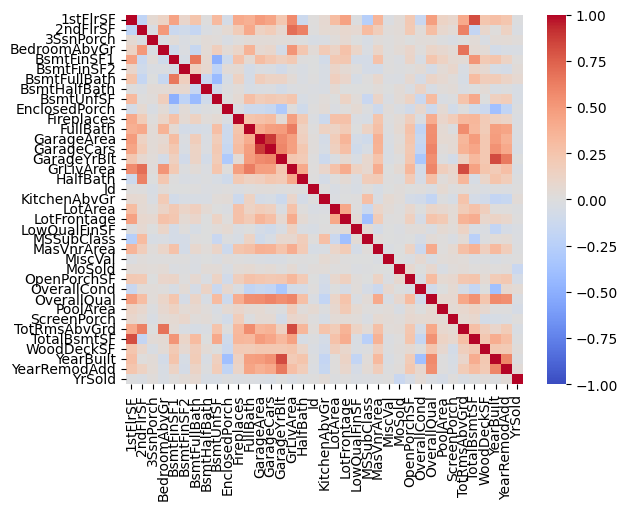

In [31]:
correlation_matrix = data[numeric_values].corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= 'coolwarm',vmin=-1, vmax=1);

<br>
Below shows the feature correlation ordered from most correlated.
<br>
We can see that GarageArea and GarageCars correlate highly as do GarageYrBlt and YearBuilt as they were likely built at the same time. 
<br>
OverallQual is the most important feature contributing to SalePrice with GrLivArea also having strong correlation with SalePrice.

In [32]:
corr_df=correlation_matrix.stack().reset_index()
corr_df.columns=['feature 1','feature 2','correlation']
corr_df.sort_values(by='correlation',ascending=False,inplace=True)
corr_df=corr_df[corr_df['feature 1'] != corr_df['feature 2']]
corr_df.head(12)

,feature 1,feature 2,correlation
457,GarageArea,GarageCars,0.882475
493,GarageCars,GarageArea,0.882475
552,GarageYrBlt,YearBuilt,0.825667
1272,YearBuilt,GarageYrBlt,0.825667
586,GrLivArea,TotRmsAbvGrd,0.825489
1162,TotRmsAbvGrd,GrLivArea,0.825489
32,1stFlrSF,TotalBsmtSF,0.819530
1184,TotalBsmtSF,1stFlrSF,0.819530
52,2ndFlrSF,GrLivArea,0.687501
556,GrLivArea,2ndFlrSF,0.687501


Dropping redundant columns that are highly correlated, starting with GarageCars:

In [33]:
X.drop(columns=['GarageCars'])
test.drop(columns=['GarageCars'])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,NA,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NA,IR1,HLS,AllPub,...,144,0,NA,NA,NA,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,NA,NA,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,NA,NA,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,NA,NA,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NA,Reg,Lvl,AllPub,...,0,0,NA,MnPrv,Shed,700,7,2006,WD,Normal


Using Spearman's rank to check ordinally encoded features correlation:

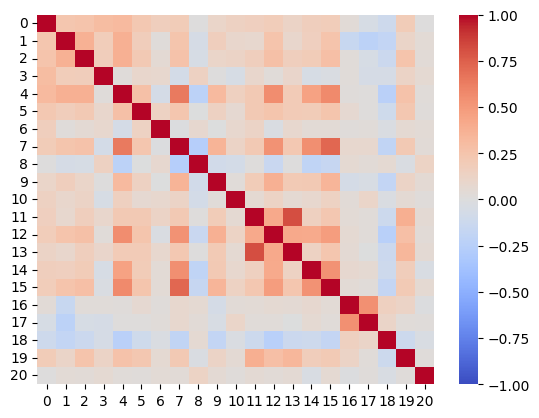

In [34]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))
corr_matrix_ord = X_ordinally_encoded.corr(method='spearman')
column_names = corr_matrix_ord.columns
sns.heatmap(corr_matrix_ord, xticklabels=column_names, yticklabels=column_names, cmap='coolwarm', vmin=-1, vmax=1);

In [35]:
corr_ordinal=X_ordinally_encoded.stack().reset_index()
corr_ordinal.columns=['feature 1','feature 2','correlation']
corr_ordinal.sort_values(by='correlation', ascending=False,inplace=True)
corr_ordinal=corr_ordinal[corr_ordinal['feature 1']!= corr_ordinal['feature 2']]
corr_ordinal.head(12)

,feature 1,feature 2,correlation
12197,580,17,1.0
21082,1003,19,1.0
6305,300,5,1.0
21089,1004,5,1.0
14402,685,17,1.0
21086,1004,2,1.0
14404,685,19,1.0
10729,510,19,1.0
21080,1003,17,1.0
21096,1004,12,1.0


Removing the least important features that contribute least to the prediction of the target. 
<br> Helps to prevent overfitting and shortens the training time.

Using SelectPercentile to remove any features that least explain the target

In [36]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only 50% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x129899930>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x12998bc70>))])

Using VarianceThreshold to remove the features with the lowest variance.
<br>  Unsupervised selection: Filter based only on the properties of `X`

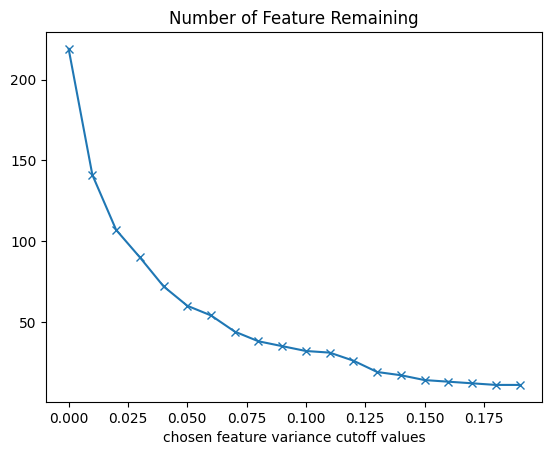

In [38]:
from sklearn.feature_selection import VarianceThreshold

def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, numeric_values),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop")

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector)

    return preproc.fit_transform(X).shape[1]

cutoff_values = np.arange(0, 0.2, 0.01)
plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')
plt.xlabel("chosen feature variance cutoff values")
plt.title("Number of Feature Remaining");

### Target Engineering

Transforming to log normalizes the data so is easier to predict with linear models.

Text(0.5, 0, 'log(SalePrice)')

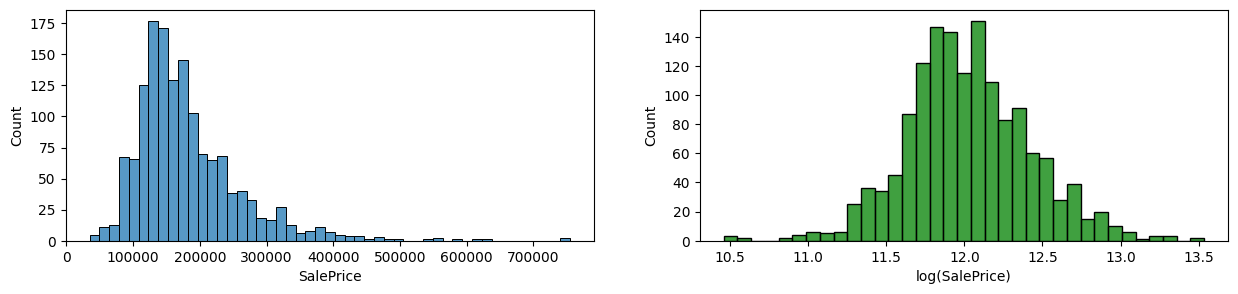

In [39]:
y_log = np.log(y)
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.histplot(y)
plt.subplot(1,2,2)
sns.histplot(y_log, color='green')
plt.xlabel("log(SalePrice)")

In [40]:
# new scorer to minimize
from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

#new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

In [41]:
preproc.fit_transform(X,y).shape
preproc_log = preproc.fit(X,y_log)
preproc_log.transform(X).shape

(1460, 109)

## Final Version of the Preproc pipeline

In [43]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only 50% of all features )
)
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1296e75e0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x12998bc70>))])

In [45]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)
preproc_fitted_log.transform(X).shape

(1460, 109)

### Ridge

In [57]:
model=Ridge()
pipe_ridge=make_pipeline(preproc,model)
cross_val_score(pipe_ridge,X,y_log,cv=5,scoring=rmse).mean()

0.14017808780871888

using grid search with ridge regularization

In [60]:
param_grid={'ridge__alpha': np.linspace(0.5,2,num=20)}
search_ridge=GridSearchCV(pipe_ridge,param_grid=param_grid, cv=5,n_jobs=-1,verbose=2,scoring=rmse_neg)

search_ridge.fit(X,y_log);
print(search_ridge.best_params)
search_ridge.best_score

Fitting 5 folds for each of 20 candidates, totalling 100 fits


AttributeError: 'GridSearchCV' object has no attribute 'best_params'

### KNN

In [54]:
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)

In [55]:
scores = cross_val_score(pipe_knn, X, y_log
                         , cv=5, scoring=rmse)
scores.mean()

0.1982829852667528

In [48]:
# GridSearch the KNN
param_grid =  {'kneighborsregressor__n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
search_knn = GridSearchCV(pipe_knn, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=2, scoring=rmse_neg)

search_knn.fit(X, y_log);
print(search_knn.best_params_)
search_knn.best_score_

Fitting 3 folds for each of 11 candidates, totalling 33 fits
{'kneighborsregressor__n_neighbors': 6}


-0.20514653895095136

[CV] END .................kneighborsregressor__n_neighbors=3; total time=   1.9s
[CV] END .................kneighborsregressor__n_neighbors=7; total time=   1.8s
[CV] END ................kneighborsregressor__n_neighbors=10; total time=   2.6s
[CV] END ................kneighborsregressor__n_neighbors=30; total time=   2.4s
[CV] END .................kneighborsregressor__n_neighbors=5; total time=   1.9s
[CV] END .................kneighborsregressor__n_neighbors=8; total time=   1.8s
[CV] END ................kneighborsregressor__n_neighbors=10; total time=   2.5s
[CV] END ................kneighborsregressor__n_neighbors=20; total time=   2.3s
[CV] END .................kneighborsregressor__n_neighbors=5; total time=   1.9s
[CV] END .................kneighborsregressor__n_neighbors=6; total time=   1.8s
[CV] END .................kneighborsregressor__n_neighbors=8; total time=   2.5s
[CV] END ................kneighborsregressor__n_neighbors=15; total time=   2.4s
[CV] END .................kn

### Random Forrest

In [ ]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)
pipe = make_pipeline(preproc, model)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()